In [4]:
#Import Statements
import tensorflow as tf
from keras.models import Sequential # type: ignore
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from keras.optimizers import Adam # type: ignore
import numpy as np  # type: ignore # for numerical operations
import pandas as pd  # type: ignore # for dataset operations
import matplotlib.pyplot as plt # type: ignore # for plotting
import os # for file operations
import cv2 # type: ignore # for image processing
import imghdr #type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #type: ignore


In [5]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [6]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
#Avoid OOM errors by setting GPU memory consumption growth
#Only Run if using the alienware for training
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

    Remove corrupt/incompatible images

In [8]:
data_dir = "data"
os.listdir(data_dir)

['Atopic Dermatitis - 1257',
 'Benign Keratosis-like Lesions (BKL) -2079',
 'Eczema - 1677',
 'Melanoma - 3140',
 'Psoriasis pictures Lichen Planus and related diseases - 2055',
 'Seborrheic Keratoses and other Benign Tumors - 1847',
 'Warts Molluscum and other Viral Infections - 2103']

In [9]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
#for image_class in os.listdir(data_dir):
    #for image in os.listdir(os.path.join(data_dir, image_class)):
        #image_path = os.path.join(data_dir, image_class, image)
        #try: 
            #img = cv2.imread(image_path) #checking for valid image path and valid image extension
            #tip = imghdr.what(image_path)
            #if tip not in image_exts:
                #print('Image not in ext list {}'.format(image_path))
                #os.remove(image_path)
        #except Exception as e:
            #print('Issue with image {}'.format(image_path))

            # 2m 52.5s

load data (using pipeline to avoid loading data into memory simultaneously), Data isn't preloaded into memory rather generated on the fly by the pipeline, meaning we cant do data[0] to view our dataset, we have to do more complicated procedure. This step is absolutely necessary because of the massive size of our dataset...

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data') #creates batch size, image size, etc..

Found 14158 files belonging to 7 classes.


In [12]:
data_iterator = data.as_numpy_iterator() #creates an iterator for the dataset, #allows us to access data pipeline
batch = data_iterator.next() #gets the next batch of data from the iterator, #accesses data pipeline
#batch
len(batch)

2

In [13]:
batch[0].shape #batch[0] is the images, batch[1] is the labels

(32, 256, 256, 3)

In [14]:
batch[1]

array([2, 6, 3, 3, 3, 5, 6, 4, 5, 4, 2, 6, 3, 0, 3, 3, 4, 3, 3, 5, 0, 6,
       4, 3, 2, 1, 0, 1, 3, 5, 4, 1], dtype=int32)

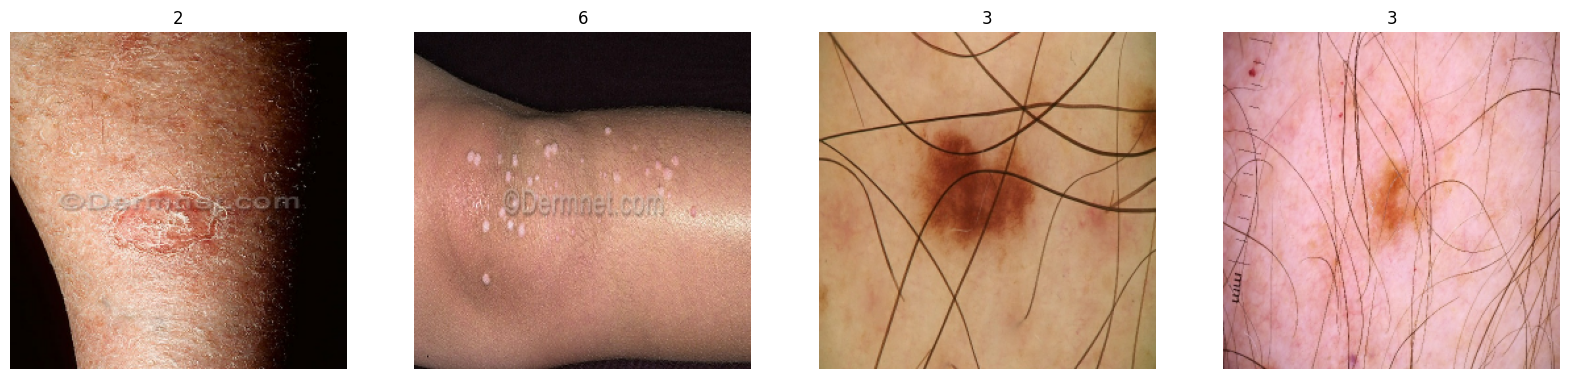

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #creates a figure with 4 subplots
for idx, img in enumerate(batch[0][:4]): #iterates over the first 4 images in the batch
        ax[idx].imshow(img.astype('uint8')) #displays the image in the subplot
        ax[idx].set_title(batch[1][idx]) #sets the title of the subplot to the label of the image
        ax[idx].axis('off') #turns off the axis for the subplot

        #images in key/index 0, labels in key/index 1

Preprocessing Data

In [16]:
batch[0].max()

np.float32(255.0)

In [17]:
scaled = batch[0] / 255
scaled.max() #max value of the scaled image is 1, min value is 0

np.float32(1.0)

In [18]:
data = data.map(lambda x, y: (x / 255, y)) #scales the images to be between 0 and 1
data.as_numpy_iterator().next() #gets the next batch of data from the iterator, #accesses data pipeline


(array([[[[1.26363352e-01, 2.71461397e-01, 3.73422176e-01],
          [1.39874384e-01, 2.85845578e-01, 3.85186881e-01],
          [1.49019614e-01, 2.98039228e-01, 3.88235301e-01],
          ...,
          [6.23529434e-01, 5.05882382e-01, 3.96078438e-01],
          [6.29626215e-01, 5.08930743e-01, 3.96078438e-01],
          [6.35003090e-01, 5.02542913e-01, 3.92447919e-01]],
 
         [[1.26130283e-01, 2.71461397e-01, 3.72722983e-01],
          [1.36034861e-01, 2.84447163e-01, 3.76465142e-01],
          [1.42738968e-01, 2.91758567e-01, 3.79623950e-01],
          ...,
          [6.29810035e-01, 5.12162983e-01, 4.02359068e-01],
          [6.31024659e-01, 5.10329187e-01, 3.97476852e-01],
          [6.29188597e-01, 5.05450130e-01, 3.92447919e-01]],
 
         [[1.30922452e-01, 2.73497641e-01, 3.69929522e-01],
          [1.34496406e-01, 2.78277040e-01, 3.69926125e-01],
          [1.38556987e-01, 2.83309698e-01, 3.67003679e-01],
          ...,
          [6.30400479e-01, 5.15669644e-01, 4.0683

In [19]:
scaled_iterator = data.as_numpy_iterator() #creates an iterator for the dataset, #allows us to access data pipeline
scaled_batch = scaled_iterator.next() #gets the next batch of data from the iterator, #accesses data pipeline
scaled_batch[0].max() #max value of the scaled image is 1, min value is 0

np.float32(1.0)

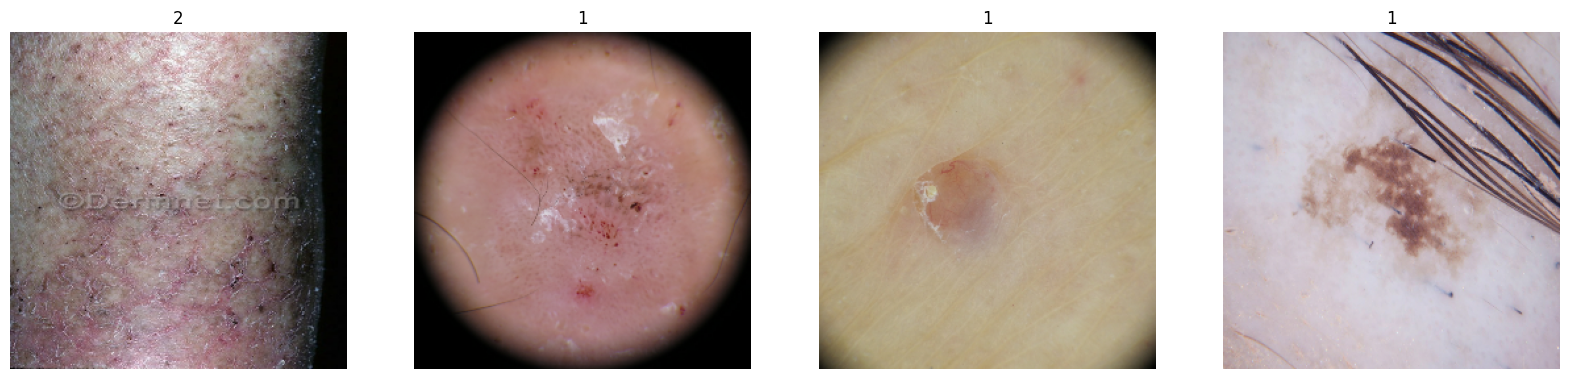

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #creates a figure with 4 subplots
for idx, img in enumerate(scaled_batch[0][:4]): #iterates over the first 4 images in the batch
        ax[idx].imshow(img) #displays the image in the subplot
        ax[idx].set_title(scaled_batch[1][idx]) #sets the title of the subplot to the label of the image
        ax[idx].axis('off') #turns off the axis for the subplot

        #images in key/index 0, labels in key/index 1

Scaling Images

In [21]:
len(data)
#number of batches total, each batch has 32 images

443

In [22]:
train_size = int(len(data) * 0.7) #70% of the data is used for training #310 images per batch
val_size = int(len(data) * 0.2) #20% of the data is used for validation #88 images per batch
test_size = int(len(data) * 0.1) #10% of the data is used for testing #44 images per batch

In [23]:
test_size+val_size+train_size

442

In [24]:
train = data.take(train_size) #takes the first 70% of the data for training
val = data.skip(train_size).take(val_size) #takes the next 20% of the data for validation
test = data.skip(train_size + val_size).take(test_size) #takes the last 10% of the data for testing
len(train), len(val), len(test) #number of batches in each dataset

(310, 88, 44)

Building the Actual Models

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #first layer, input, 3 channels, stride of 1, 16 filters
model.add(MaxPooling2D()) #takes max values after relu activation and returns that value and condenses the information (by half)

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'relu')) #output layer, 1 neuron, sigmoid activation function

c:\Users\maxkr\Documents\Sr.Proj-STopicsS2-Proj-Code-Repo\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy']) #compiles the model, adam optimizer, binary crossentropy loss function, accuracy metric

In [28]:
model.summary() #prints the summary of the model, shows the layers, output shape, number of parameters, etc.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Time to Train!

In [29]:
logdir = 'logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #creates a tensorboard callback to log the training process, logs to the logdir directory